# Time Series Modelling: Stock prices data

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from datetime import datetime
import seaborn as sns

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Data

In [2]:
## Historical BSE stock prices from 2017-06-29 to 2018-06-29, (Yahoo! Finance)
data = pd.read_csv("^BSESN.csv")
data = data.set_index("Date")
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-29,30910.970703,31097.919922,30794.609375,30857.519531,30857.519531,12300
2017-06-30,30824.970703,30965.449219,30680.660156,30921.609375,30921.609375,9200
2017-07-03,31156.039063,31258.330078,31017.109375,31221.619141,31221.619141,8100
2017-07-04,31331.210938,31353.460938,31166.369141,31209.789063,31209.789063,8700
2017-07-05,31272.720703,31284.640625,31177.779297,31245.560547,31245.560547,6500


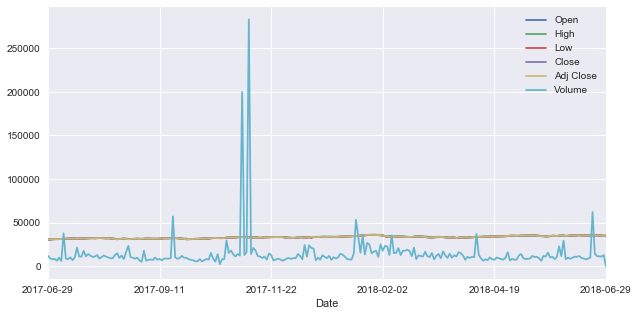

In [3]:
data.plot(figsize = (10,5))
plt.show()

In [4]:
s , e = data.index[0], data.index[-1]
index = pd.date_range(s,e, freq = 'B') #business days
index_s = pd.Series(index, index = index)

In [5]:
# Closing prices time series
TS = pd.Series.to_frame(data['Close']).join(pd.Series.to_frame(index_s))
TS = TS['Close']
TS[pd.isnull(TS)]

Series([], Name: Close, dtype: float64)

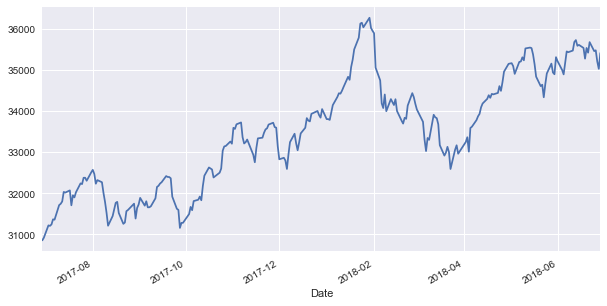

pandas.core.series.Series

In [6]:
TS.plot(figsize = (10,5))
plt.show()
type(TS)

# Model selection

## Autocorrelation

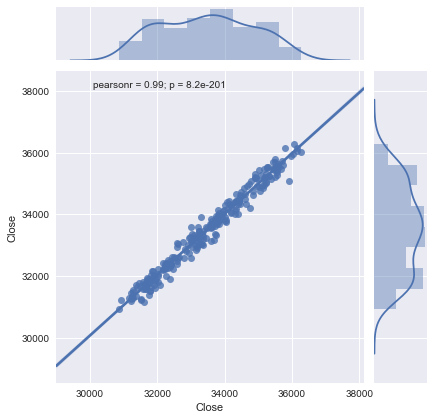

In [7]:
# lag=1 correlation on time series
sns.jointplot(TS.shift(1), TS, kind = 'reg')
plt.show()

In [8]:
df = pd.concat([TS.shift(1), TS], axis = 1)
df.columns = ['t-1', 't']
result = df.corr()
print(result)

          t-1         t
t-1  1.000000  0.987454
t    0.987454  1.000000


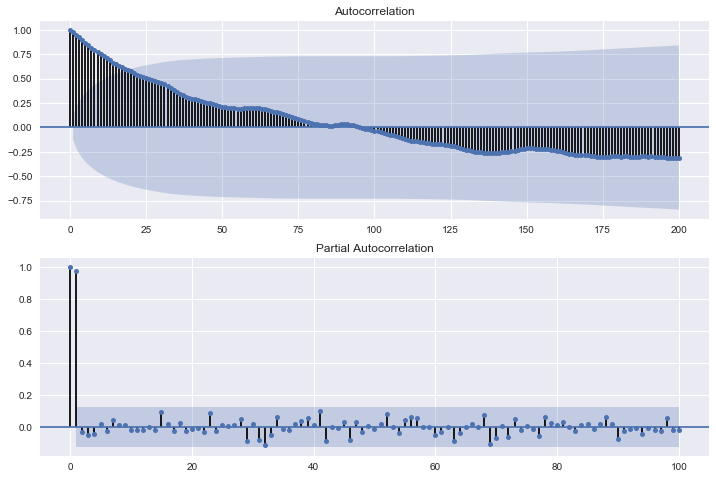

In [9]:
#Arbitrary lag correlations on time series 
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(TS, lags = 200, ax = ax1) #autocorrelation function
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(TS, lags = 100, ax = ax2) #partial autocorrelation function



* PACF function is significant at lag(1) and drops off after that. This suggests time series follows a AR(1) model.
* ACF function is significant up until lag = 10. This suggest the time series follows a MA(10) model.


## Stationarity

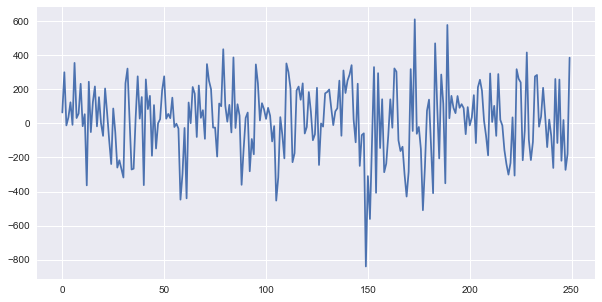

In [21]:
#First differenced time series
fig = plt.figure(figsize = (10,5))
#diff = sm.tsa.statespace.tools.diff(TS, k_diff = 1)
diff = (TS - TS.shift(1))[1:]
plt.plot(range(250), diff.values)
plt.show()

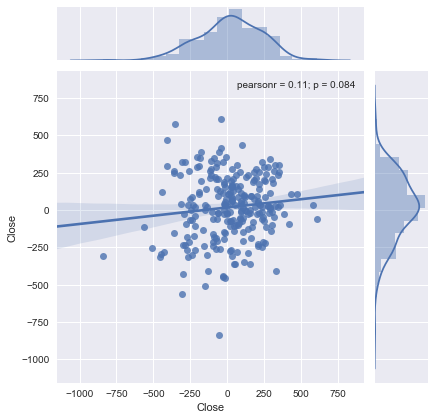

In [11]:
#Lag = 1 correlation of differenced time series
sns.jointplot(diff.shift(1), diff, kind = 'reg')
plt.show()

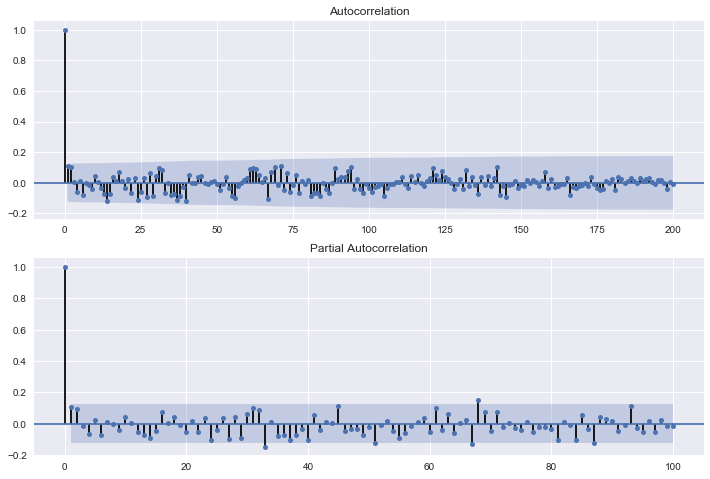

In [12]:
# Autocorrelation function of the first differencing
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(diff, lags = 200, ax = ax1) #autocorrelation function
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(diff, lags = 100, ax = ax2) #partial autocorrelation function


* The ACF and PACF functiond of the differenced time series are insignificant. Therefore the differenced time series follows a random walk model. This implies the original time series is stationary

In [13]:
#window = 10
#moving_avg = pd.Series.rolling(TS, window = window, center = True).mean()[window:-window]

# Model Training

## AutoRegressive Moving Average model

In [14]:
# split dataset for training and testing
from datetime import timedelta
test_size = 100
train = TS[0:len(TS)-test_size]
test = TS[-test_size:]

In [15]:
#Train autoregressor
model_arma = sm.tsa.ARMA(TS, order = (1,10)).fit()

In [16]:
model_arma.params

const           33358.041682
ar.L1.Close         0.988005
ma.L1.Close         0.116121
ma.L2.Close         0.123723
ma.L3.Close         0.027550
ma.L4.Close        -0.024726
ma.L5.Close         0.033827
ma.L6.Close        -0.072938
ma.L7.Close         0.012208
ma.L8.Close        -0.011748
ma.L9.Close        -0.047080
ma.L10.Close        0.064646
dtype: float64

### Predictions

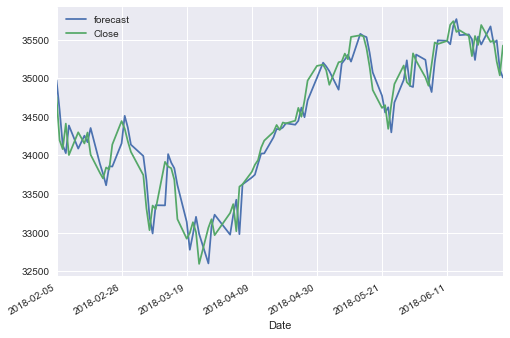

In [18]:
start = TS.index[len(TS)-100]
end = TS.index[-1]
predictions = model_arma.predict(start, end , dynamic = False)
model_arma.plot_predict(start, end, dynamic = False)

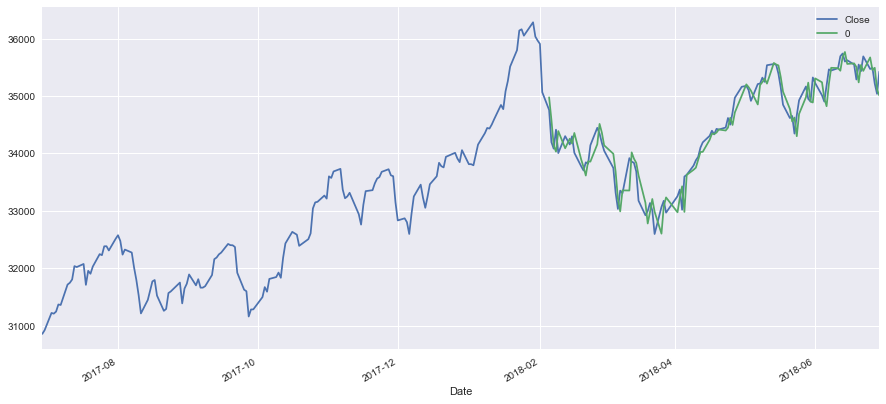

In [20]:
prediction_df = pd.Series.to_frame(TS).join(pd.Series.to_frame(predictions))
prediction_df.plot(figsize = (15,7))
plt.show()